Ranking among the top ten most visited websites globally as of 2018, Reddit stands as a prominent online forum and anonymized social media platform. Hosting diverse discussions across an expansive range of subjects, Reddit, like Facebook, possesses a notable capacity to influence individual perceptions, often leading to the formation of 'echo chambers.' This research aims to identify distinctive linguistic patterns within specific online subcultures and develop a predictive model capable of assigning a given sentence to its most probable group of origin.

## Domain Specific Language
Reddit - the overall site and forum

Subreddit - a thematically focused subsection of reddit containing threads, images, links etc.

Post - a forum in a subreddit which has a title and a body.  The body could be an image, text, or a link to another site.

Comment - a message sent by a user for a given post

Using a scheduleable python script I aggregated data from four subreddits, below.  The goal was to use subreddits that would potentially clash in the types of posts and comments you would find there.
* funny
* philosophy
* The_Donald
* SandersForPresident

This data was collected for a variable number of subreddits and then merged together into a final csv representation.  The fields in our final representation are as follows
* sub - the subreddit the comment was posted on
* Username - name of user who posted the comment
* Comment - the comment body posted by the user
* sentiment - the numeric value, positive or negative, indicating whether the comment was positive or negative.  This was not initially in the dataset but I've included it here for reasons I will discuss later

The goal was to be able to predict the subreddit given nothing more than the username and the comment.  Though the former is currently not a part of a model it could be used as part of a more nuanced approach of identifying users and groups of users behaviors.  For the remainder of this notebook we will be relying solely on comment to extract features.

More plainly, our target is the subreddit of origin and our predictor variables are all derived from the comment

In [85]:
import pandas as pd
from collections import Counter
import nltk
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import tree
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
cols = ['sub', 'username', 'comment']
df = pd.read_csv('https://raw.githubusercontent.com/Image17/reddit-data/master/merged.csv', sep='|', names=cols)
df.head()

,sub,username,comment
0,funny,spaceborat,It's a Russian spy seagull
1,funny,notagoodboye,"Normally I'm not all ""It's a big pharma conspi..."
2,funny,thegreenmile777,I think I know that gull... Oh well.. Privac...
3,funny,skylego,Takes at least two years before it can remotel...
4,funny,ManiacalDane,Knowing about the Spidey sequel way before IW ...


In [3]:
print('Total comments', len(df))
print('Subreddit targets',df['sub'].unique())

print('Comment count by subreddit',df.groupby(['sub'], sort=False).size().reset_index(name='Count'))

Total comments 8925
Subreddit targets ['funny' 'philosophy' 'SandersForPresident' 'The_Donald']
Comment count by subreddit                    sub  Count
0                funny   2482
1           philosophy   1782
2  SandersForPresident   1128
3           The_Donald   3533


In [102]:
stop_words = nltk.corpus.stopwords.words('english')
s = df.loc[df['sub'] == 'The_Donald', 'comment'].str.cat()
f=[]
for w in s.split():
    if w not in stop_words:
        f.append(w)

td_words = Counter(f)
srt = sorted(td_words.items(), key=lambda item: item[1])
srt[-10:]

[('going', 143),
 ('They', 147),
 ('one', 180),
 ('think', 186),
 ('get', 217),
 ('The', 230),
 ('would', 260),
 ('people', 283),
 ('like', 367),
 ('I', 800)]

In [106]:
s = df.loc[df['sub'] == 'SandersForPresident', 'comment'].str.cat()
f=[]
for w in s.split():
    if w not in stop_words:
        f.append(w)

sfp_words = Counter(f)
srt = sorted(sfp_words.items(), key=lambda item: item[1])
srt[-10:]

[('think', 108),
 ('get', 117),
 ('Biden', 121),
 ('one', 125),
 ('would', 152),
 ('like', 174),
 ('|', 195),
 ('people', 209),
 ('Bernie', 270),
 ('I', 477)]

In [105]:
s = df.loc[df['sub'] == 'philosophy', 'comment'].str.cat()
f=[]
for w in s.split():
    if w not in stop_words:
        f.append(w)

p_words = Counter(f)
srt = sorted(p_words.items(), key=lambda item: item[1])
srt[-10:]

[('even', 238),
 ('If', 255),
 ('one', 288),
 ('This', 293),
 ('The', 334),
 ('people', 380),
 ('think', 388),
 ('like', 403),
 ('would', 412),
 ('I', 1712)]

In [104]:
s = df.loc[df['sub'] == 'funny', 'comment'].str.cat()
f=[]
for w in s.split():
    if w not in stop_words:
        f.append(w)

f_words = Counter(f)
srt = sorted(f_words.items(), key=lambda item: item[1])
srt[-10:]

[('see', 73),
 ('know', 88),
 ('think', 90),
 ('get', 123),
 ('would', 124),
 ('people', 135),
 ('one', 138),
 ('like', 191),
 ('Hitler', 471),
 ('I', 563)]

In [8]:
df_sent = pd.read_csv('https://raw.githubusercontent.com/Image17/reddit-data/master/merged_sent.csv', sep='\t')
df_sent.head()

,sub,username,comment,sentiment
0,funny,spaceborat,It's a Russian spy seagull,0
1,funny,notagoodboye,"Normally I'm not all ""It's a big pharma conspi...",8
2,funny,thegreenmile777,I think I know that gull... Oh well.. Privac...,0
3,funny,skylego,Takes at least two years before it can remotel...,-4
4,funny,ManiacalDane,Knowing about the Spidey sequel way before IW ...,0


In [9]:
# Ensure we have the same targets and the same number of comments

print('Total comments without sentiment', len(df))
print('Total comments with sentiment',len(df_sent))

Total comments without sentiment 8925
Total comments with sentiment 8925


In [10]:
print('Subreddit targets without sentiment',df['sub'].unique())
print('Subreddit targets with sentiment',df_sent['sub'].unique())

Subreddit targets without sentiment ['funny' 'philosophy' 'SandersForPresident' 'The_Donald']
Subreddit targets with sentiment ['funny' 'philosophy' 'SandersForPresident' 'The_Donald']


In [11]:
print('Comment count by subreddit without sentiment\n',df.groupby(['sub'], sort=False).size().reset_index(name='Count'))
print('Comment count by subreddit with sentiment\n',df_sent.groupby(['sub'], sort=False).size().reset_index(name='Count'))

Comment count by subreddit without sentiment
                    sub  Count
0                funny   2482
1           philosophy   1782
2  SandersForPresident   1128
3           The_Donald   3533
Comment count by subreddit with sentiment
                    sub  Count
0                funny   2482
1           philosophy   1782
2  SandersForPresident   1128
3           The_Donald   3533


In [12]:
# Going forward df_sent will be df1 to separate any different experiments
df1 = df_sent
df1.head()

,sub,username,comment,sentiment
0,funny,spaceborat,It's a Russian spy seagull,0
1,funny,notagoodboye,"Normally I'm not all ""It's a big pharma conspi...",8
2,funny,thegreenmile777,I think I know that gull... Oh well.. Privac...,0
3,funny,skylego,Takes at least two years before it can remotel...,-4
4,funny,ManiacalDane,Knowing about the Spidey sequel way before IW ...,0


In [13]:
# Extracting length of comment
df1['chars'] = df1['comment'].str.len()
df1.head()

,sub,username,comment,sentiment,chars
0,funny,spaceborat,It's a Russian spy seagull,0,26
1,funny,notagoodboye,"Normally I'm not all ""It's a big pharma conspi...",8,221
2,funny,thegreenmile777,I think I know that gull... Oh well.. Privac...,0,75
3,funny,skylego,Takes at least two years before it can remotel...,-4,154
4,funny,ManiacalDane,Knowing about the Spidey sequel way before IW ...,0,93


In [14]:
# Get count of words in comment
df1['words'] = [len(str(comment).split(" ")) for comment in df1['comment']]
df1.head()

,sub,username,comment,sentiment,chars,words
0,funny,spaceborat,It's a Russian spy seagull,0,26,5
1,funny,notagoodboye,"Normally I'm not all ""It's a big pharma conspi...",8,221,41
2,funny,thegreenmile777,I think I know that gull... Oh well.. Privac...,0,75,16
3,funny,skylego,Takes at least two years before it can remotel...,-4,154,26
4,funny,ManiacalDane,Knowing about the Spidey sequel way before IW ...,0,93,18


In [15]:
def average_words(comment):
    '''Calculate average word length for a given comment'''
    words = comment.split()
    return (sum(len(word) for word in words)/len(words))

In [16]:
# Get average word length for a given comment
df1['words_avg'] = [average_words(comment) for comment in df1['comment']]
df1.head()

,sub,username,comment,sentiment,chars,words,words_avg
0,funny,spaceborat,It's a Russian spy seagull,0,26,5,4.400000
1,funny,notagoodboye,"Normally I'm not all ""It's a big pharma conspi...",8,221,41,4.414634
2,funny,thegreenmile777,I think I know that gull... Oh well.. Privac...,0,75,16,4.285714
3,funny,skylego,Takes at least two years before it can remotel...,-4,154,26,4.961538
4,funny,ManiacalDane,Knowing about the Spidey sequel way before IW ...,0,93,18,4.222222


In [89]:
# Count the number of stop words in each comment
df1['stop_words'] = [len([word for word in comment.split() if word in stop_words]) for comment in df1['comment']]
df1.head()

,sub,username,comment,sentiment,chars,words,words_avg,stop_words,hastrump,hasmueller,hasmarine,hasamerica,hasrussia,politic,science,hasbernie,The_Donald,SandersForPresident,philosophy,funny
0,funny,spaceborat,It's a Russian spy seagull,0,26,5,4.400000,1,0,0,0,0,1,0,0,0,False,False,False,True
1,funny,notagoodboye,"Normally I'm not all ""It's a big pharma conspi...",8,221,41,4.414634,18,0,0,0,0,0,0,0,0,False,False,False,True
2,funny,thegreenmile777,I think I know that gull... Oh well.. Privac...,0,75,16,4.285714,4,0,0,0,0,0,0,0,0,False,False,False,True
3,funny,skylego,Takes at least two years before it can remotel...,-4,154,26,4.961538,12,0,0,0,0,0,0,0,0,False,False,False,True
4,funny,ManiacalDane,Knowing about the Spidey sequel way before IW ...,0,93,18,4.222222,8,0,0,0,0,0,0,0,0,False,False,False,True


In [ ]:
# This is not going to work here because I have not uploaded the backing dataset to a uniformly accessible place 
# putting this here simply for documentation purposes.

uni_polarity={}
multi_polarity={}

def analyze_u(s):
    p=0
    load_uni_polarity()
    for w in s.split():
        if w in uni_polarity:
            p += int(uni_polarity[w])
    if p > 0:
        return p
    elif p < 0:
        return p
    else:
        return p
        
def analyze_m(s):
    best_phrase=''
    best_match=0.0
    curr_match=0.0
    best_pol=0
    load_multi_polarity()
    for phrase in multi_polarity:
        curr_match=0
        if s in phrase:
            #print(s, phrase)
            curr_match = len(s.split()) / len(phrase.split())
        if curr_match > best_match:
            best_match = curr_match
            best_phrase = phrase
            best_pol = multi_polarity[phrase]
    
    #this part is still a bit buggy
    if not best_phrase:
        return analyze_u(s)
    else:
        return(best_pol)

def load_multi_polarity():
    with open('.spyder-py3/SA/train.tsv', newline='', encoding='UTF-8-sig') as data:
        reader = csv.reader(data, delimiter='\t')
        for row in reader:
            multi_polarity.update({row[2]:row[3]})
            
def load_uni_polarity():
    with open('.spyder-py3/SA/unigram.csv', newline='', encoding='UTF-8-sig') as data:
        reader = csv.reader(data, delimiter=',')
        for row in reader:
            uni_polarity.update({row[0]:row[1]})

In [ ]:
# We will not be doing this now, because it is embarassingly slow
#df1['sentiment'] = [analyze_m(comment) for comment in df1['comment']]
#df1.head()

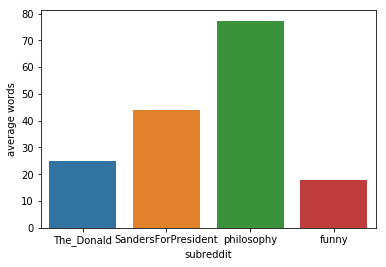

In [86]:
td_avg_words = df1.loc[df1['sub'] == 'The_Donald', 'words'].sum() / (len(df1.loc[df1['sub'] == 'The_Donald', 'words']))
sfp_avg_words = df1.loc[df1['sub'] == 'SandersForPresident', 'words'].sum() / (len(df1.loc[df1['sub'] == 'SandersForPresident', 'words']))
p_avg_words = df1.loc[df1['sub'] == 'philosophy', 'words'].sum() / (len(df1.loc[df1['sub'] == 'philosophy', 'words']))
f_avg_words = df1.loc[df1['sub'] == 'funny', 'words'].sum() / (len(df1.loc[df1['sub'] == 'funny', 'words']))

x = ['The_Donald', 'SandersForPresident', 'philosophy', 'funny']
y = [td_avg_words,sfp_avg_words,p_avg_words,f_avg_words]
d = {'subreddit':x, 'average words':y}

df_bar = pd.DataFrame.from_dict(d)

ax = sns.barplot(x="subreddit", y="average words", data=df_bar)
plt.show()

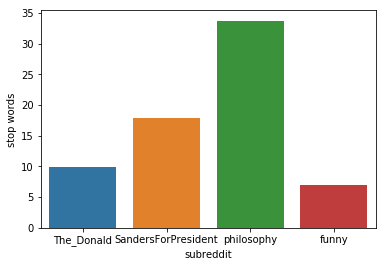

In [88]:
td_stop_words = df1.loc[df1['sub'] == 'The_Donald', 'stop_words'].sum() / (len(df1.loc[df1['sub'] == 'The_Donald', 'stop_words']))
sfp_stop_words = df1.loc[df1['sub'] == 'SandersForPresident', 'stop_words'].sum() / (len(df1.loc[df1['sub'] == 'SandersForPresident', 'stop_words']))
p_stop_words = df1.loc[df1['sub'] == 'philosophy', 'stop_words'].sum() / (len(df1.loc[df1['sub'] == 'philosophy', 'stop_words']))
f_stop_words = df1.loc[df1['sub'] == 'funny', 'stop_words'].sum() / (len(df1.loc[df1['sub'] == 'funny', 'stop_words']))

x = ['The_Donald', 'SandersForPresident', 'philosophy', 'funny']
y = [td_stop_words,sfp_stop_words,p_stop_words,f_stop_words]
d = {'subreddit':x, 'stop words':y}

df_bar = pd.DataFrame.from_dict(d)

ax = sns.barplot(x="subreddit", y="stop words", data=df_bar)
plt.show()

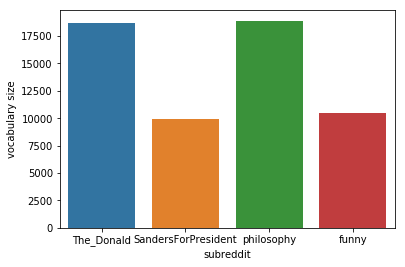

In [98]:
# vocab size - not a feature but maybe it should be
td_unique_words = set(df.loc[df['sub'] == 'The_Donald', 'comment'].str.cat().split())
td_vocab = len(td_unique_words)

sfp_unique_words = set(df.loc[df['sub'] == 'SandersForPresident', 'comment'].str.cat().split())
sfp_vocab = len(sfp_unique_words)

p_unique_words = set(df.loc[df['sub'] == 'philosophy', 'comment'].str.cat().split())
p_vocab = len(p_unique_words)

f_unique_words = set(df.loc[df['sub'] == 'funny', 'comment'].str.cat().split())
f_vocab = len(f_unique_words)

x = ['The_Donald', 'SandersForPresident', 'philosophy', 'funny']
y = [td_vocab,sfp_vocab,p_vocab,f_vocab]
d = {'subreddit':x, 'vocabulary size':y}

df_bar = pd.DataFrame.from_dict(d)

ax = sns.barplot(x="subreddit", y="vocabulary size", data=df_bar)
plt.show()

## Applying machine learning

### First approach, bag of words - no context, no sentiment
Here we will attempt to predict subreddit given no context or sentiment of the comments.  We are attempting to predict 1 of 4 subreddits

In [18]:
X1 = df1.drop('sub', axis=1)
X1 = X1.drop('comment', axis=1)
X1 = X1.drop('username', axis=1)
X1 = X1.drop('sentiment', axis=1)
y1 = df1['sub']
X1.head()

,chars,words,words_avg,stop_words
0,26,5,4.400000,1
1,221,41,4.414634,18
2,75,16,4.285714,4
3,154,26,4.961538,12
4,93,18,4.222222,8


In [19]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, random_state=1, test_size=0.2)
model1 = tree.DecisionTreeClassifier()

model1.fit(X1_train, y1_train)

y1_predict = model1.predict(X1_test)
accuracy_score(y1_test, y1_predict)

0.37254901960784315

Ok, so that accuracy is not very high - but it is a promising start that there is at least some predictability in how users in each subreddit convey their thoughts.

### Take two, lets add context
Perhaps our simple bag of words features is limited, but if we add some context to these comments then perhaps we can discover some other patterns

In [20]:
df2 = df1
df2.head()

,sub,username,comment,sentiment,chars,words,words_avg,stop_words
0,funny,spaceborat,It's a Russian spy seagull,0,26,5,4.400000,1
1,funny,notagoodboye,"Normally I'm not all ""It's a big pharma conspi...",8,221,41,4.414634,18
2,funny,thegreenmile777,I think I know that gull... Oh well.. Privac...,0,75,16,4.285714,4
3,funny,skylego,Takes at least two years before it can remotel...,-4,154,26,4.961538,12
4,funny,ManiacalDane,Knowing about the Spidey sequel way before IW ...,0,93,18,4.222222,8


In [21]:
def has_word(comment, word):
    """
    This function will determine whether a word is contained in a comment or not in a case insensitive manner.
    1 if true 0 otherwise
    """
    if re.search(word, comment, re.IGNORECASE):
        return 1
    else:
        return 0

In [107]:
# add context to comments

df2['hastrump'] = [has_word(comment,'trump') for comment in df2['comment']]
df2['hasmueller'] = [has_word(comment,'mueller') for comment in df2['comment']]
df2['hasmarine'] = [has_word(comment,'marine') for comment in df2['comment']]
df2['hasamerica'] = [has_word(comment,'america') for comment in df2['comment']]
df2['hasrussia'] = [has_word(comment,'russia') for comment in df2['comment']]
df2['politic'] = [has_word(comment,'politic') for comment in df2['comment']]
df2['science'] = [has_word(comment,'science') for comment in df2['comment']]
df2['hasbernie'] = [has_word(comment,'bernie') for comment in df2['comment']]
df2.head()

,sub,username,comment,sentiment,chars,words,words_avg,stop_words,hastrump,hasmueller,hasmarine,hasamerica,hasrussia,politic,science,hasbernie,The_Donald,SandersForPresident,philosophy,funny
0,funny,spaceborat,It's a Russian spy seagull,0,26,5,4.400000,1,0,0,0,0,1,0,0,0,False,False,False,True
1,funny,notagoodboye,"Normally I'm not all ""It's a big pharma conspi...",8,221,41,4.414634,18,0,0,0,0,0,0,0,0,False,False,False,True
2,funny,thegreenmile777,I think I know that gull... Oh well.. Privac...,0,75,16,4.285714,4,0,0,0,0,0,0,0,0,False,False,False,True
3,funny,skylego,Takes at least two years before it can remotel...,-4,154,26,4.961538,12,0,0,0,0,0,0,0,0,False,False,False,True
4,funny,ManiacalDane,Knowing about the Spidey sequel way before IW ...,0,93,18,4.222222,8,0,0,0,0,0,0,0,0,False,False,False,True


In [23]:
X2 = df2.drop('sub', axis=1)
X2 = X2.drop('comment', axis=1)
X2 = X2.drop('username', axis=1)
X2 = X2.drop('sentiment', axis=1)
y2 = df2['sub']
X2.head()

,chars,words,words_avg,stop_words,hastrump,hasmueller,hasmarine,hasamerica,hasrussia,politic,science,hasbernie
0,26,5,4.400000,1,0,0,0,0,1,0,0,0
1,221,41,4.414634,18,0,0,0,0,0,0,0,0
2,75,16,4.285714,4,0,0,0,0,0,0,0,0
3,154,26,4.961538,12,0,0,0,0,0,0,0,0
4,93,18,4.222222,8,0,0,0,0,0,0,0,0


In [24]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, random_state=1, test_size=0.2)
model2 = tree.DecisionTreeClassifier()

model2.fit(X2_train, y2_train)

y2_predict = model2.predict(X2_test)
accuracy_score(y2_test, y2_predict)

0.41288515406162463

Well that is slightly better, but not by much.  Perhaps if we add sentiment it will enable our context to have some conviction.

## Third time is the charm, using sentiment

In [25]:
X3 = df2.drop('sub', axis=1)
X3 = X3.drop('comment', axis=1)
X3 = X3.drop('username', axis=1)
y3 = df2['sub']
X3.head()

,sentiment,chars,words,words_avg,stop_words,hastrump,hasmueller,hasmarine,hasamerica,hasrussia,politic,science,hasbernie
0,0,26,5,4.400000,1,0,0,0,0,1,0,0,0
1,8,221,41,4.414634,18,0,0,0,0,0,0,0,0
2,0,75,16,4.285714,4,0,0,0,0,0,0,0,0
3,-4,154,26,4.961538,12,0,0,0,0,0,0,0,0
4,0,93,18,4.222222,8,0,0,0,0,0,0,0,0


In [29]:
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, random_state=1, test_size=0.2)
model3 = tree.DecisionTreeClassifier()

model3.fit(X3_train, y3_train)

y3_predict = model3.predict(X3_test)
accuracy_score(y3_test, y3_predict)

0.41456582633053224

Not much better, perhaps we have too many features or we are trying to predict too many different targets.  Lets try and see if we can figure out whether something belongs to a community or not - as opposed to determining which community it belongs to

In [108]:
df2['The_Donald'] = df2['sub'] == 'The_Donald'
df2['SandersForPresident'] = df2['sub'] == 'SandersForPresident'
df2['philosophy'] = df2['sub'] == 'philosophy'
df2['funny'] = df2['sub'] == 'funny'
df2.head()

,sub,username,comment,sentiment,chars,words,words_avg,stop_words,hastrump,hasmueller,hasmarine,hasamerica,hasrussia,politic,science,hasbernie,The_Donald,SandersForPresident,philosophy,funny
0,funny,spaceborat,It's a Russian spy seagull,0,26,5,4.400000,1,0,0,0,0,1,0,0,0,False,False,False,True
1,funny,notagoodboye,"Normally I'm not all ""It's a big pharma conspi...",8,221,41,4.414634,18,0,0,0,0,0,0,0,0,False,False,False,True
2,funny,thegreenmile777,I think I know that gull... Oh well.. Privac...,0,75,16,4.285714,4,0,0,0,0,0,0,0,0,False,False,False,True
3,funny,skylego,Takes at least two years before it can remotel...,-4,154,26,4.961538,12,0,0,0,0,0,0,0,0,False,False,False,True
4,funny,ManiacalDane,Knowing about the Spidey sequel way before IW ...,0,93,18,4.222222,8,0,0,0,0,0,0,0,0,False,False,False,True


In [31]:
X4 = df2.drop('sub', axis=1)
X4 = X4.drop('comment', axis=1)
X4 = X4.drop('username', axis=1)
y4 = df2['The_Donald']
X4.head()

,sentiment,chars,words,words_avg,stop_words,hastrump,hasmueller,hasmarine,hasamerica,hasrussia,politic,science,hasbernie,The_Donald,SandersForPresident,philosophy,funny
0,0,26,5,4.400000,1,0,0,0,0,1,0,0,0,False,False,False,True
1,8,221,41,4.414634,18,0,0,0,0,0,0,0,0,False,False,False,True
2,0,75,16,4.285714,4,0,0,0,0,0,0,0,0,False,False,False,True
3,-4,154,26,4.961538,12,0,0,0,0,0,0,0,0,False,False,False,True
4,0,93,18,4.222222,8,0,0,0,0,0,0,0,0,False,False,False,True


In [32]:
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, random_state=1, test_size=0.2)
model4 = tree.DecisionTreeClassifier()

model4.fit(X4_train, y4_train)

y4_predict = model4.predict(X4_test)
accuracy_score(y4_test, y4_predict)

1.0

Now.. that can't possibly be correct?  Can it?

In [46]:
X5 = df2.drop('sub', axis=1)
X5 = X5.drop('comment', axis=1)
X5 = X5.drop('username', axis=1)
X5.head()
y5 = df2['SandersForPresident']
X5_train, X5_test, y5_train, y5_test = train_test_split(X5, y5, random_state=1, test_size=0.2)
model5 = tree.DecisionTreeClassifier()

model5.fit(X5_train, y5_train)

y5_predict = model5.predict(X5_test)
accuracy_score(y5_test, y5_predict)

1.0

In [36]:
y6 = df2['philosophy']
X4_train, X4_test, y6_train, y6_test = train_test_split(X4, y6, random_state=1, test_size=0.2)
model6 = tree.DecisionTreeClassifier()

model6.fit(X4_train, y6_train)

y6_predict = model6.predict(X4_test)
accuracy_score(y6_test, y6_predict)

1.0

In [38]:
y7 = df2['funny']
X4_train, X4_test, y7_train, y7_test = train_test_split(X4, y7, random_state=1, test_size=0.2)
model7 = tree.DecisionTreeClassifier()

model7.fit(X4_train, y7_train)

y7_predict = model4.predict(X4_test)
accuracy_score(y7_test, y7_predict)

1.0

It seems the features I have added for context do well to illuminate The_Donald speech, but it is less effective on the other subreddits.  Perhaps adding more domain specific knowledge would allow us to isolate key features for other communities as well.

## Alternate Approach, Text Vectorization via TF-IDF

In [109]:
# term frequency-inverse document frequency
# increase weight as term appears in document but lessens weight for how often 
# the word appears in the entire corpus

vdf = df2
vdf = vdf.drop('username', axis=1)
vdf = vdf.loc[:, 'sub':'comment']
vdf.head()

,sub,comment
0,funny,It's a Russian spy seagull
1,funny,"Normally I'm not all ""It's a big pharma conspi..."
2,funny,I think I know that gull... Oh well.. Privac...
3,funny,Takes at least two years before it can remotel...
4,funny,Knowing about the Spidey sequel way before IW ...


In [49]:
vdf_x = vdf['comment'] 
vdf_y = vdf['sub']

vector = TfidfVectorizer(stop_words='english', min_df=5) #if a word occurs less than 5 times ignore it

vX_train, vX_test, vy_train, vy_test = train_test_split(vdf_x, vdf_y, random_state=1, test_size=0.2)

vX_train = vector.fit_transform(vX_train)
vX_train.toarray()

vX_test = vector.transform(vX_test)

In [53]:
mnb = MultinomialNB()

mnb.fit(vX_train, vy_train)

mnb.score(vX_test, vy_test)

0.6257703081232493

Significantly better than our context-less approach with bag of words.  Perhaps it can still be improved upon by adding context.

Even with a sentiment analysis process that is not fully optimized, our results demonstrate a significant capacity to classify online comments accurately. This capability opens up a broad range of applications, notably in the identification of various speech categories such as hate speech, language patterns linked to mental health conditions, and political affiliations.